In [1]:
#Broker imports:
import py_at_broker as pab
from IPython.display import clear_output

import pylab as pl
import pickle as p
import matplotlib.pyplot as plt
%matplotlib inline
b = pab.broker()

%load_ext autoreload
%autoreload 2
from toolbox import data_processing as dp
from toolbox import movementtoolbox as mt 
#Non broker imports:

from IPython import display
import math as math
import pandas as pd
import time
import cv2
import numpy as np
import numpy.random as npr

%load_ext autoreload
%autoreload 2
from toolbox import kinematic_mapping as km
from robo_cheesecake.engine import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext autoreload
%autoreload 2
from toolbox import object_detection_toolbox as odt
import os
import tensorflow as tf

from object_detection.utils import visualization_utils as vis_util

In [3]:
b.request_signal("franka_state", pab.MsgType.franka_state, True)
current_counter=0

In [4]:
b.request_signal("franka_lidar", pab.MsgType.franka_lidar)

True

In [6]:
lidar_msg = b.recv_msg('franka_lidar', 0)
print(lidar_msg)

In [7]:
b.register_signal('franka_target_pos', pab.MsgType.target_pos)

Address broker could not acceppt the offered signal franka_target_pos. Is there another signal with the same name? Trying to reconnect
Reconnection to signal <franka_target_pos> successful


True

/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


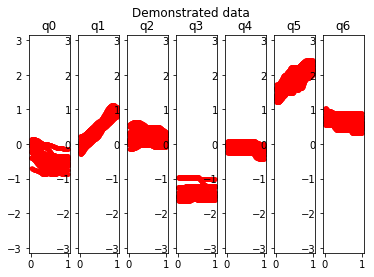

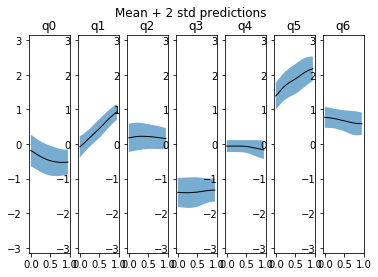

In [8]:
def PredZ(z):
    return RobotSaysHi.GeneratePrediction(w=RobotSaysHi.estimate_m, Z=z)[1]

df_generated, N=robotoolbox.PrepareData('JointsFinalPresentation_take2.p')

params = {'D' : 7, 'K' : 5, 'N' : N}
RobotSaysHi=ProMP(identifier='RobotSaysHi', TrainingData=df_generated, params=params)
RobotSaysHi.RegularizedLeastSquares() #Choice for l from [1]
RobotSaysHi.GenerateDemoPlot(xvariable="Phases")  
RobotSaysHi.MeanAndStdPredictionPlot(factor=2)
MaxTime=6
samples=1  

In [42]:
%load_ext autoreload
%autoreload 2
from toolbox import obstacle_detector as od


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
loc = od.localizer()


In [11]:
prefix = 'models/retrained_models_without_broken_lidar/model_lidar_5000_epochs'
predictor, predictions, measurements = od.init_lidar_predictor(b, timesteps = 5, model_prefix=prefix)

Done loading model 0
Done loading model 1
Done loading model 2
Done loading model 3
Done loading model 4
Done loading model 5
Done loading model 6
Done loading model 7
Done loading model 8
initializing measurements: .....done


In [12]:
w_sampled=npr.multivariate_normal(RobotSaysHi.estimate_m,RobotSaysHi.estimate_sigma)
T, Q = RobotSaysHi.GetJointData(w= w_sampled, robotrate=samples, MaxTime=MaxTime)

In [66]:
#Q_des=end_pos
#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m), Q_des], Ztarget=[0,z])        
#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m),PredZ(0.3) ,PredZ(0.35) , Q_des], Ztarget=[0,0.3,0.35,z])        
#filename = 'panning\scan_desk_11_10_'
#cols = ['timestamp_franka', 'joint_pos', 'joint_vel', 'endeff_pos', 'timestamp_lidar', 'lidar_data']
#df = pd.DataFrame(columns = cols)
polarity=1

send_position = 0   
check_for_error = 0
sampling_rate = 0.05
lidars = []
joints = []

pos_counter = -1

samples = 1
sleep_time = samples
go_time = 1.8*samples

err_count = 0



while True:
    
    time.sleep(sampling_rate)
    state_msg = b.recv_msg("franka_state", 0)
    lidar_msg = b.recv_msg("franka_lidar", 0)
    
    lidars.append(lidar_msg.get_data())
    joints.append(state_msg.get_j_pos())
    
    check_for_error += 1
    send_position += sampling_rate
    
    if send_position > 1:
        
        
        if pos_counter == -1:
            print('sampled new')
            w_sampled=npr.multivariate_normal(RobotSaysHi.estimate_m,RobotSaysHi.estimate_sigma)
            T, Q = RobotSaysHi.GetJointData(w= w_sampled, robotrate=samples, MaxTime=MaxTime)
            polarity = 1
            pos_counter+=polarity
        elif pos_counter == 6:
            print('reversed')
            polarity = -1  
            pos_counter+=polarity
        else:
            pos_counter+=polarity
        
        
        Q_pos = Q[pos_counter]
        frame=current_counter+1
        target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Q_pos, go_time=go_time)
        b.send_msg('franka_target_pos', target_msg)
        #state_msg = b.recv_msg("franka_state", 0)
        #lidar_msg = b.recv_msg("franka_lidar", 0)
        send_position = 0 
        print(pos_counter)
        
    if check_for_error > 10:  
        clear_output(wait = True)
        prediction, measurement = predictor.predict_timeseries(joint_data=np.array(joints), true_lidar=np.array(lidars))
        #measurement = medfilt(measurement, 5)
        #od.calc_error(predictor, predictions, measurements, np.array(lidars), np.array(joints), 0.4)
        error, idx = od.compare2threshold(prediction, measurement, 0.3, all_errors = True)
        
        if error: 
            if type(idx) == int:
                #location = loc.localize_lidars(joint_angles=state_msg.get_j_pos())
                lidar_measurement=lidar_msg.get_data()
                obstacle = loc.localize_obstacle(joint_pos=state_msg.get_j_pos(),
                                                 lidar_measurement=lidar_measurement, 
                                                 lidar_index=idx)
                print('location of obstacle', obstacle)
                print('current lidar value', lidar_measurement)
                print('lidar positions ', loc.localize_lidars(state_msg.get_j_pos()))
                coll = loc.predict_collision(future_joint_angels=Q[pos_counter+1:].T, obstacle_location=obstacle)
                print(coll)
                #plt.plot(prediction[:, idx], label = 'prediction')
                #plt.plot(measurement[:, idx], label = 'measurement')
                #plt.title('error in lidar {}'.format(idx))
                #plt.legend()
                #plt.savefig('error'+str(err_count)+'.png')     
                #plt.show()

                if coll[0]: 
                    #clear_output()
                    print('returning to avoid collision')
                    pos_counter = -1
                    time.sleep(2)
                

            if type(idx) == np.ndarray: 
                colls = []
                #location = loc.localize_lidars(joint_angles=state_msg.get_j_pos())
                lidar_measurement=lidar_msg.get_data()
                for i in idx:             
                    obstacle = loc.localize_obstacle(joint_pos=state_msg.get_j_pos(),
                                                 lidar_measurement=lidar_measurement, 
                                                 lidar_index=i)
                    print('location of obstacle', obstacle)
                    print('current lidar value', lidar_measurement)
                    print('lidar positions ', loc.localize_lidars(state_msg.get_j_pos()))
                    coll = loc.predict_collision(future_joint_angels=Q[pos_counter+1:].T, obstacle_location=obstacle)
                    colls.append(coll[0])
                #plt.plot(prediction[:, idx], label = 'prediction')
                #plt.plot(measurement[:, idx], label = 'measurement')
                #plt.title('error in lidar {}'.format(idx))
                #plt.legend()
                #plt.savefig('error'+str(err_count)+'.png')     
                #plt.show()

                if np.array(colls).any(): 
                    #clear_output()
                    print('returning to avoid collision')
                    pos_counter = -1
                    time.sleep(2)


                
        lidars = []
        joints = []       
        check_for_error = 0
                
            #err_count +=1
            #time.sleep(1)

        
        
        
    #save_and_send+=0.1

Deviation of 0.45 in liadar 7.
obstacle found in front left top
location of obstacle [0.257 0.181 0.619]
current lidar value [8190 1113 8191  580 8191 8190 8191  210 1779]
lidar positions  [[ 0.513 -0.229  0.64 ]
 [ 0.551 -0.101  0.704]
 [ 0.595 -0.123  0.626]
 [ 0.528 -0.102  0.566]
 [ 0.553 -0.033  0.633]
 [ 0.121 -0.178  0.607]
 [ 0.169 -0.021  0.681]
 [ 0.211 -0.023  0.599]
 [ 0.174  0.055  0.629]]
1


KeyboardInterrupt: 

In [35]:
while True: 
    clear_output(wait=True)
    time.sleep(0.05)
    lidar_msg = b.recv_msg("franka_lidar", 0)
    print(lidar_msg.get_data())

    
    

KeyboardInterrupt: 

In [ ]:
loc.lidarDF

In [ ]:
b.request_signal("realsense_images", pab.MsgType.realsense_image)

In [ ]:
camera_msg = b.recv_msg("realsense_images", 0)
img_array = camera_msg.get_rgb()
img_dim = camera_msg.get_shape_rgb()
img = np.reshape(img_array, img_dim)

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.savefig('notfranka9.png', bbox_inches ='tight')

In [63]:
type(np.array([7, 2]))==np.ndarray

True